# Time Series Forecasting with Deep Learning

#### Importing libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import time
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, \
    SimpleRNN, InputLayer, Conv1D, Activation, Add, Flatten, \
    Multiply, TimeDistributed, GRU, RNN, SimpleRNNCell
from keras.models import Model
from tensorflow.keras.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error 
from sklearn.preprocessing import MinMaxScaler

<font color='blue'>Times Series Forecasting Exercise: Instructions</font>
1. Choose a dataset
2. Visualize the dataset
3. Split data - Use the last 20% of values as test
5. Use 4 model architectures that we demonstrated in class
123123. Explain which strategy was the best and why you think it was the best

#### Importing the data

In [3]:
df = pd.read_csv('https://storage.googleapis.com/nicksdemobucket/passenger.csv')

#### Inspecting the data

In [4]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [6]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [7]:
print('The time series has %i rows and %i columns'%(df.shape[0], df.shape[1]))

The time series has 144 rows and 2 columns


In [8]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

#### Visualizing the data

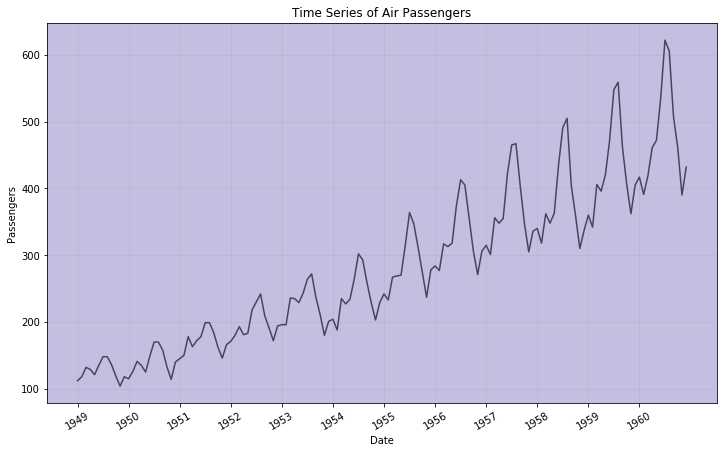

In [9]:
ax, figure = fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), linewidth=1)
plt.plot(df['Month'], df['Passengers'], color='#48435C')
locs, labels=plt.xticks(df['Month'][::12],  np.arange(1949, 1961), rotation=30)
ax.set_facecolor('#C5BEE0')
plt.title('Time Series of Air Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True, alpha=0.05, color='black')
plt.show()

Notice the strong seasonality

#### Getting shifted data

In [10]:
for i in range(1, 13):
    df['Month–%s'%i] = df['Passengers'].shift(i)

In [11]:
df.head()

,Month,Passengers,Month–1,Month–2,Month–3,Month–4,Month–5,Month–6,Month–7,Month–8,Month–9,Month–10,Month–11,Month–12
0,1949-01,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1949-04,129,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1949-05,121,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Splitting the data into train and test sets

In [12]:
train = df.iloc[:-24].set_index('Month')
train.head()

,Passengers,Month–1,Month–2,Month–3,Month–4,Month–5,Month–6,Month–7,Month–8,Month–9,Month–10,Month–11,Month–12
Month,,,,,,,,,,,,,
1949-01,112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-02,118,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-03,132,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-04,129,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1949-05,121,129.0,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train.shape

(120, 13)

In [14]:
test = df.iloc[-24:].set_index('Month')
test.head()

,Passengers,Month–1,Month–2,Month–3,Month–4,Month–5,Month–6,Month–7,Month–8,Month–9,Month–10,Month–11,Month–12
Month,,,,,,,,,,,,,
1959-01,360,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0
1959-02,342,360.0,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0
1959-03,406,342.0,360.0,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0
1959-04,396,406.0,342.0,360.0,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0
1959-05,420,396.0,406.0,342.0,360.0,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0


In [15]:
test.shape

(24, 13)

As demanded by the instructor...

In [16]:
test.shape[0]/train.shape[0]

0.2

Splitting `X` and `y`

In [17]:
X_train, y_train = train, train['Passengers'].shift(-1)

In [18]:
y_train = y_train.rename('Target')

In [19]:
X_test, y_test = test[:-1], test['Passengers'].shift(-1)[:-1]

In [20]:
y_test = y_test.rename('Target')

#### Handling the missing values

In [21]:
X_train=X_train.fillna(method='ffill', axis=1)

In [22]:
X_test.head()

,Passengers,Month–1,Month–2,Month–3,Month–4,Month–5,Month–6,Month–7,Month–8,Month–9,Month–10,Month–11,Month–12
Month,,,,,,,,,,,,,
1959-01,360,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0,340.0
1959-02,342,360.0,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0,318.0
1959-03,406,342.0,360.0,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0,362.0
1959-04,396,406.0,342.0,360.0,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0,348.0
1959-05,420,396.0,406.0,342.0,360.0,337.0,310.0,359.0,404.0,505.0,491.0,435.0,363.0


In [23]:
sum([X_train.isnull().sum().sum(), X_test.isnull().sum().sum(),
   y_train.isnull().sum().sum(), y_test.isnull().sum().sum()])

1

One missing value. Let's look that up

In [24]:
y_train.tail()

Month
1958-08    404.0
1958-09    359.0
1958-10    310.0
1958-11    337.0
1958-12      NaN
Name: Target, dtype: float64

In [25]:
y_train[-1] = y_train[-2] # missing value caused by the shift

The data is ready. Let's run a simple model to have a benchmark performance

In [26]:
pd.concat([X_train, y_train], axis=1, sort=False).head()

,Passengers,Month–1,Month–2,Month–3,Month–4,Month–5,Month–6,Month–7,Month–8,Month–9,Month–10,Month–11,Month–12,Target
Month,,,,,,,,,,,,,,
1949-01,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,118.0
1949-02,118.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,132.0
1949-03,132.0,118.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,129.0
1949-04,129.0,132.0,118.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,121.0
1949-05,121.0,129.0,132.0,118.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,112.0,135.0


In [27]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120, 13), (23, 13), (120,), (23,))

### 1 Naïve Method 

In [28]:
y_pred_naive = df['Passengers'][-24:-1]

In [29]:
mae_naive = mean_absolute_error(y_test, y_pred_naive)
mae_naive

45.130434782608695

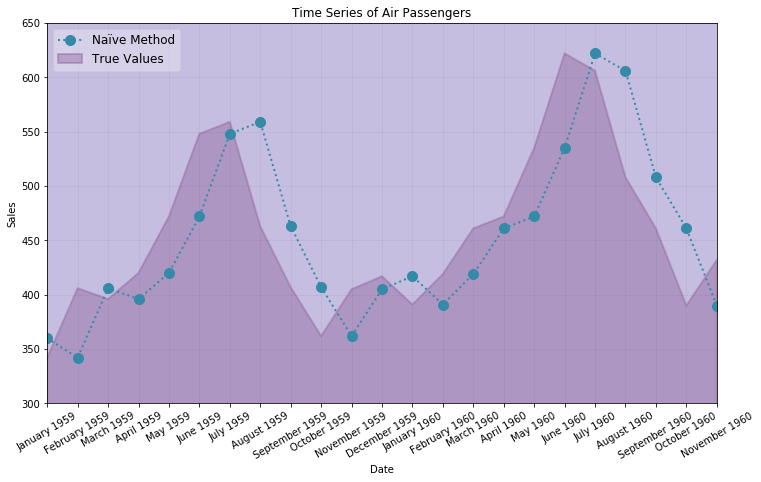

In [30]:
ax, figure = fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
plt.fill_between(X_test.index, 0, y_test, color='#8D5A97', linewidth=2, alpha=4e-1)
plt.plot(X_test.index, y_pred_naive, color='#348AA7', linewidth=2, linestyle=':', 
         marker='o', markersize=10)
locs, labels=plt.xticks(X_test.index[::],  pd.to_datetime(df.Month[-24:]).dt.strftime('%B %Y'), rotation=30)
ax.set_facecolor('#C5BEE0')
plt.title('Time Series of Air Passengers')
plt.ylabel('Sales')
ax.legend(('Naïve Method', 'True Values'), framealpha=0.3, fontsize='large')
plt.grid(True, alpha=0.05, color='black')
plt.ylim(300, 650)
plt.xlim(X_test.index[0], X_test.index[-1])
plt.xlabel('Date')
plt.show()

In [31]:
print('The mean absolute error with a naïve model is %i'%mae_naive)

The mean absolute error with a naïve model is 45


In [32]:
error_df = pd.DataFrame([mae_naive], index=['Naïve'], columns=['Mean Absolute Error'])
error_df

,Mean Absolute Error
Naïve,45.130435


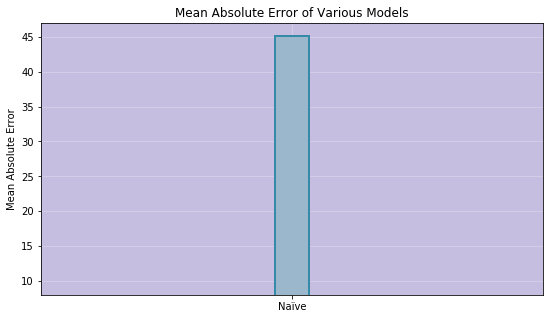

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
color='#9BB7CC'
edgecolor='#348AA7'
ax.bar(error_df.index, height=error_df['Mean Absolute Error'], 
       color=color, width=4e-1, lw=2, edgecolor=edgecolor)
ax.set_ylim(8, 47)
ax.set_xlim(-3, 3)
ax.set_facecolor('#C5BEE0')
plt.title('Mean Absolute Error of Various Models')
ax.set_ylabel('Mean Absolute Error')
ax.grid(True, color='white', alpha=0.3)
ax.set_axisbelow(True)
plt.show()

Let's do another benchmark method, a simple model

### 2 Linear regression

In [34]:
reg = LinearRegression()

In [35]:
reg.fit(np.array(X_train), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
y_pred_reg = reg.predict(X_test)

In [37]:
mae_reg = mean_absolute_error(y_test, y_pred_reg)
mae_reg

14.244720199453745

Visualizing the predicted data

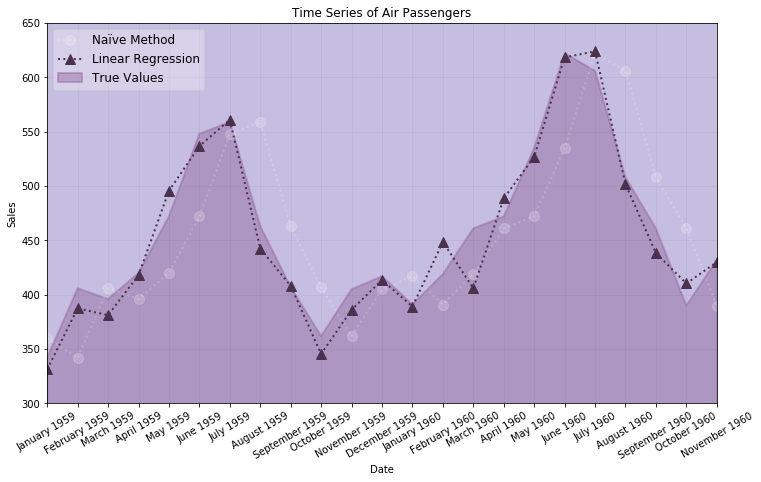

In [38]:
ax, figure = fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
plt.fill_between(X_test.index, 0, y_test, color='#8D5A97', linewidth=2, alpha=4e-1)
plt.plot(X_test.index, y_pred_naive, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='o', markersize=10, alpha=2e-1)
plt.plot(X_test.index, y_pred_reg, color='#4A314D', linewidth=2, linestyle=':', 
         marker='^', markersize=10)
locs, labels=plt.xticks(X_test.index[::],  pd.to_datetime(df.Month[-24:]).dt.strftime('%B %Y'), rotation=30)
ax.set_facecolor('#C5BEE0')
plt.title('Time Series of Air Passengers')
plt.ylabel('Sales')
ax.legend(('Naïve Method', 'Linear Regression', 'True Values'), framealpha=0.3, fontsize='large')
plt.grid(True, alpha=0.05, color='black')
plt.ylim(300, 650)
plt.xlim(X_test.index[0], X_test.index[-1])
plt.xlabel('Date')
plt.show()

In [39]:
print('The mean absolute error with a regression model is %i'%mae_reg)

The mean absolute error with a regression model is 14


In [40]:
error_df = pd.concat([error_df, pd.DataFrame([mae_reg], index=['Linear Regression'], columns=['Mean Absolute Error'])])
error_df

,Mean Absolute Error
Naïve,45.130435
Linear Regression,14.244720


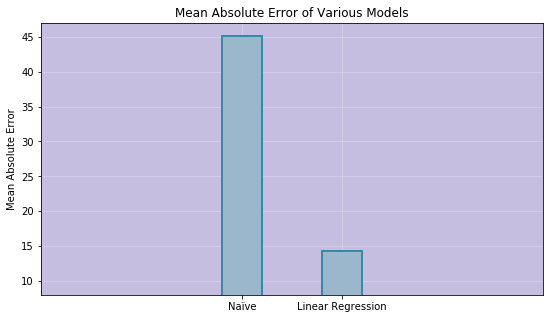

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
color='#9BB7CC'
edgecolor='#348AA7'
ax.bar(error_df.index, height=error_df['Mean Absolute Error'], 
       color=color, width=4e-1, lw=2, edgecolor=edgecolor)
ax.set_ylim(8, 47)
ax.set_xlim(-2, 3)
ax.set_facecolor('#C5BEE0')
plt.title('Mean Absolute Error of Various Models')
ax.set_ylabel('Mean Absolute Error')
ax.grid(True, color='white', alpha=0.3)
ax.set_axisbelow(True)
plt.show()

### 3 Dense neural network

Re-scaling the data for the neural network

In [42]:
X_train_copy=X_train.copy()
X_test_copy=X_test.copy()
y_train_copy=y_train.copy()
y_test_copy=y_test.copy()

In [43]:
X_train = X_train_copy.values
X_test = X_test_copy.values
y_train = y_train_copy.values
y_test = y_test_copy.values

Re-scaling the data

In [44]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [45]:
X_scaler.fit(np.vstack([X_train, X_test]))
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [46]:
y_scaler.fit(np.vstack([y_train.reshape(-1, 1), y_test.reshape(-1, 1)]))
y_train = y_scaler.transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

Reshaping again

In [47]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

In [48]:
X_test.shape, X_train.shape

((23, 13), (120, 13))

Model parameters

In [49]:
input_shape = X_train.shape[1]
callbacks = EarlyStopping(monitor='val_loss', patience=2_00, restore_best_weights=True)
batch_size = 16

In [50]:
input_shape

13

Building the model

In [52]:
model = Sequential([
    Dense(64, input_shape=(input_shape,), activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='elu'),
    Dense(1, activation='linear')
])

Compiling the model

In [53]:
model.compile(optimizer='adam',
             loss='mean_absolute_error')

Training the model

In [55]:
history = model.fit(X_train, y_train,
                   epochs=1_000,
                   batch_size=batch_size,
                   callbacks=[callbacks],
                   validation_data=[X_test, y_test],
                   verbose=0)

In [56]:
y_pred_dense = model.predict(X_test)

In [57]:
y_pred_dense = y_scaler.inverse_transform(y_pred_dense)
y_test = y_scaler.inverse_transform(y_test)

In [58]:
mae_dense = mean_absolute_error(y_test, y_pred_dense)
mae_dense

8.83240276834239

In [59]:
y_test.shape

(23, 1)

In [60]:
y_test[:, 0].shape

(23,)

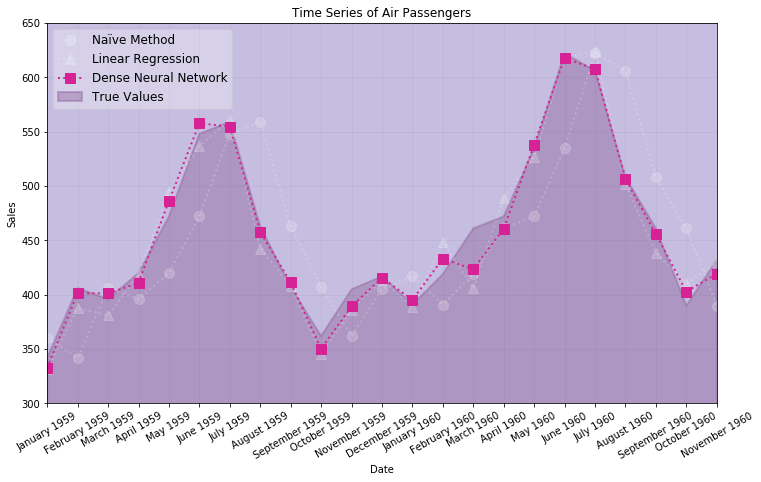

In [61]:
ax, figure = fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
plt.fill_between(X_test_copy.index, 0, y_test[:, 0], color='#8D5A97', linewidth=2, alpha=4e-1)
plt.plot(X_test_copy.index, y_pred_naive, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='o', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_reg, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='^', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_dense, color='#D62294', linewidth=2, linestyle=':', 
         marker='s', markersize=10)
locs, labels=plt.xticks(X_test_copy.index,  pd.to_datetime(df.Month[-24:]).dt.strftime('%B %Y'), rotation=30)
ax.set_facecolor('#C5BEE0')
plt.title('Time Series of Air Passengers')
plt.ylabel('Sales')
ax.legend(('Naïve Method', 'Linear Regression', 'Dense Neural Network', 'True Values'), framealpha=0.3, fontsize='large')
plt.grid(True, alpha=0.05, color='black')
plt.ylim(300, 650)
plt.xlim(X_test_copy.index[0], X_test_copy.index[-1])
plt.xlabel('Date')
plt.show()

In [62]:
print('The mean absolute error with a fully-connected (dense) neural network is %i'%mae_dense)

The mean absolute error with a fully-connected (dense) neural network is 8


In [63]:
error_df = pd.concat([error_df, pd.DataFrame([mae_dense], index=['Dense'], columns=['Mean Absolute Error'])])
error_df

,Mean Absolute Error
Naïve,45.130435
Linear Regression,14.244720
Dense,8.832403


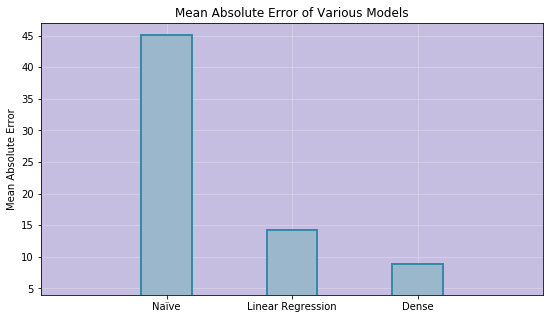

In [66]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
color='#9BB7CC'
edgecolor='#348AA7'
ax.bar(error_df.index, height=error_df['Mean Absolute Error'], 
       color=color, width=4e-1, lw=2, edgecolor=edgecolor)
ax.set_ylim(4, 47)
ax.set_xlim(-1, 3)
ax.set_facecolor('#C5BEE0')
plt.title('Mean Absolute Error of Various Models')
ax.set_ylabel('Mean Absolute Error')
ax.grid(True, color='white', alpha=0.3)
ax.set_axisbelow(True)
plt.show()

### 4 Recurrent neural network

Reshaping the data for the LSTM

In [67]:
X_train = X_train_copy.values
X_test = X_test_copy.values
y_train = y_train_copy.values
y_test = y_test_copy.values

In [68]:
np.vstack([X_train, X_test]).shape

(143, 13)

In [69]:
np.hstack([y_train, y_test]).shape

(143,)

Re-scaling the data

In [70]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [71]:
X_scaler.fit(np.vstack([X_train, X_test]))
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [72]:
y_scaler.fit(np.vstack([y_train.reshape(-1, 1), y_test.reshape(-1, 1)]))
y_train = y_scaler.transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

Reshaping again

In [73]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [74]:
X_test.shape, X_train.shape

((23, 1, 13), (120, 1, 13))

Model parameters

In [75]:
callbacks = EarlyStopping(monitor='val_loss', patience=2_00, restore_best_weights=True)

Building the model

In [76]:
model = Sequential([
    LSTM(16, input_shape=(1, 13)),
    Dense(1)
    ])

Compiling the model

In [77]:
model.compile(optimizer='adam',
             loss='mean_absolute_error')

Training the model

In [78]:
start_timer=time.time()
history = model.fit(X_train, y_train,
                   epochs=2_000,
                   callbacks=[callbacks],
                   validation_data=[X_test, y_test],
                   verbose=0)
stop_timer=time.time()
stop_timer-start_timer

21.32331943511963

In [79]:
y_pred_lstm = model.predict(X_test)

In [80]:
y_pred_lstm = y_scaler.inverse_transform(y_pred_lstm)
y_test = y_scaler.inverse_transform(y_test)

In [81]:
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mae_lstm

24.81953629203465

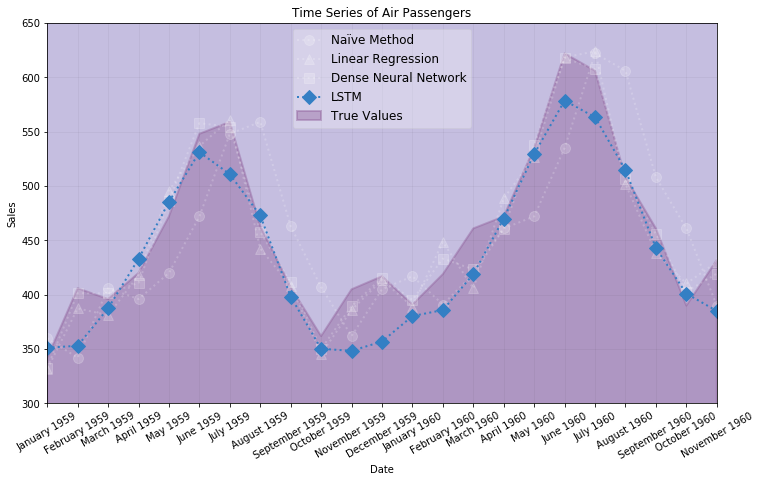

In [82]:
ax, figure = fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
plt.fill_between(X_test_copy.index, 0, y_test_copy, color='#8D5A97', linewidth=2, alpha=4e-1)
plt.plot(X_test_copy.index, y_pred_naive, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='o', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_reg, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='^', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_dense, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='s', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_lstm, color='#347FC4', linewidth=2, linestyle=':', 
         marker='D', markersize=10)
locs, labels=plt.xticks(X_test_copy.index[::],  pd.to_datetime(df.Month[-24:]).dt.strftime('%B %Y'), rotation=30)
ax.set_facecolor('#C5BEE0')
plt.title('Time Series of Air Passengers')
plt.ylabel('Sales')
ax.legend(('Naïve Method', 'Linear Regression', 'Dense Neural Network', 'LSTM', 'True Values'), framealpha=0.3, fontsize='large')
plt.grid(True, alpha=0.05, color='black')
plt.ylim(300, 650)
plt.xlim(X_test_copy.index[0], X_test_copy.index[-1])
plt.xlabel('Date')
plt.show()

In [83]:
print('The mean absolute error with a LSTM neural network is %i'%mae_lstm)

The mean absolute error with a LSTM neural network is 24


In [84]:
error_df = pd.concat([error_df, pd.DataFrame([mae_lstm], index=['LSTM'], columns=['Mean Absolute Error'])])
error_df

,Mean Absolute Error
Naïve,45.130435
Linear Regression,14.244720
Dense,8.832403
LSTM,24.819536


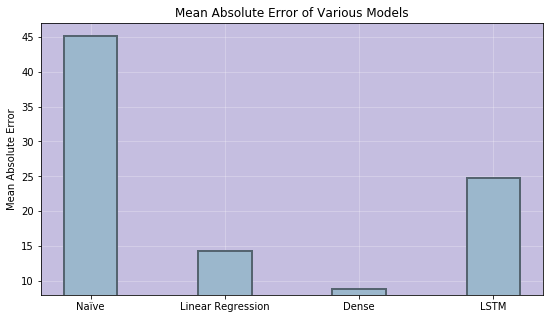

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
color='#9BB7CC'
edgecolor='#556470'
ax.bar(error_df.index, height=error_df['Mean Absolute Error'], 
       color=color, width=4e-1, lw=2, edgecolor=edgecolor)
ax.set_ylim(8, 47)
ax.set_facecolor('#C5BEE0')
plt.title('Mean Absolute Error of Various Models')
ax.set_ylabel('Mean Absolute Error')
ax.grid(True, color='white', alpha=0.3)
ax.set_axisbelow(True)
plt.show()

### 5 Deep RNN

In [86]:
X_train = X_train_copy.values
X_test = X_test_copy.values
y_train = y_train_copy.values
y_test = y_test_copy.values

Re-scaling the data

In [87]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [88]:
X_scaler.fit(np.vstack([X_train, X_test]))
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [89]:
y_scaler.fit(np.vstack([y_train.reshape(-1, 1), y_test.reshape(-1, 1)]))
y_train = y_scaler.transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

Reshaping again

In [90]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [91]:
X_test.shape, X_train.shape

((23, 1, 13), (120, 1, 13))

Model parameters

In [92]:
callbacks = EarlyStopping(monitor='val_loss', patience=2_00, restore_best_weights=True)

Building the model

In [93]:
model = Sequential([
    SimpleRNN(20, return_sequences=True, input_shape=[None, 13]),
    SimpleRNN(40),
    Dense(1)
])

Compiling the model

In [94]:
model.compile(optimizer='adam',
             loss='mean_absolute_error')

Training the model

In [95]:
start_timer=time.time()
history = model.fit(X_train, y_train,
                   epochs=1_000,
                   callbacks=[callbacks],
                   validation_data=[X_test, y_test],
                   verbose=0)
stop_timer=time.time()
stop_timer-start_timer

19.605483531951904

In [96]:
y_pred_drnn = model.predict(X_test)

In [97]:
y_pred_drnn = y_scaler.inverse_transform(y_pred_drnn)
y_test = y_scaler.inverse_transform(y_test)

In [98]:
mae_drnn = mean_absolute_error(y_test, y_pred_drnn)
mae_drnn

13.736608090608016

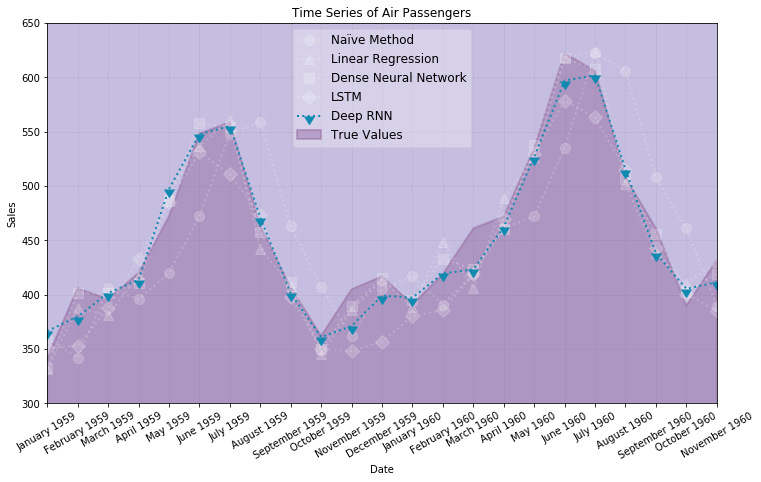

In [100]:
ax, figure = fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
plt.fill_between(X_test_copy.index, 0, y_test_copy, color='#8D5A97', linewidth=2, alpha=4e-1)

plt.plot(X_test_copy.index, y_pred_naive, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='o', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_reg, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='^', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_dense, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='s', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_lstm, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='D', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_drnn, color='#118AB2', linewidth=2, linestyle=':', 
         marker=11, markersize=10)

locs, labels=plt.xticks(X_test_copy.index[::],  
                        pd.to_datetime(df.Month[-24:]).dt.strftime('%B %Y'), 
                        rotation=30)
ax.set_facecolor('#C5BEE0')
plt.title('Time Series of Air Passengers')
plt.ylabel('Sales')
ax.legend(('Naïve Method', 'Linear Regression', 'Dense Neural Network', 'LSTM', 
           'Deep RNN', 'True Values'), framealpha=0.3, fontsize='large')
plt.grid(True, alpha=0.05, color='black')
plt.ylim(300, 650)
plt.xlim(X_test_copy.index[0], X_test_copy.index[-1])
plt.xlabel('Date')
plt.show()

In [101]:
print('The mean absolute error with a deep recurrent neural network is %i'%mae_drnn)

The mean absolute error with a deep recurrent neural network is 13


In [102]:
error_df = pd.concat([error_df, pd.DataFrame([mae_drnn], index=['Deep RNN'], columns=['Mean Absolute Error'])])
error_df

,Mean Absolute Error
Naïve,45.130435
Linear Regression,14.244720
Dense,8.832403
LSTM,24.819536
Deep RNN,13.736608


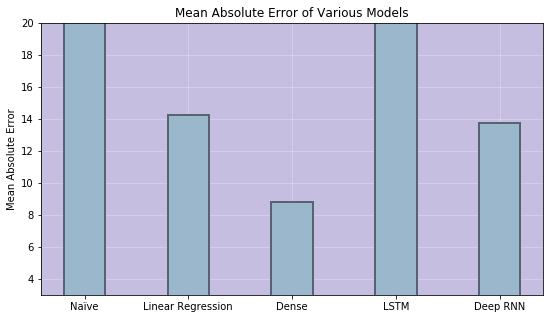

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
color='#9BB7CC'
edgecolor='#556470'
ax.bar(error_df.index, height=error_df['Mean Absolute Error'], 
       color=color, width=4e-1, lw=2, edgecolor=edgecolor)
ax.set_ylim(3, 20)
ax.set_facecolor('#C5BEE0')
ax.set_ylabel('Mean Absolute Error')
ax.grid(True, color='white', alpha=0.3)
ax.set_axisbelow(True)
plt.title('Mean Absolute Error of Various Models')
plt.show()

### 6 Simple RNN Cell

In [106]:
X_train = X_train_copy.iloc[:, 0].values
X_test = X_test_copy.iloc[:, 0].values
y_train = y_train_copy.values
y_test = y_test_copy.values

Re-scaling the data

In [107]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [108]:
X_scaler.fit(np.vstack([X_train.reshape(-1, 1), X_test.reshape(-1, 1)]))
X_train = X_scaler.transform(X_train.reshape(-1, 1))
X_test = X_scaler.transform(X_test.reshape(-1, 1))

In [109]:
y_scaler.fit(np.vstack([y_train.reshape(-1, 1), y_test.reshape(-1, 1)]))
y_train = y_scaler.transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

Reshaping again

In [110]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [111]:
y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1]))

In [112]:
X_test.shape, X_train.shape

((23, 1, 1), (120, 1, 1))

In [113]:
y_test.shape, y_train.shape

((23, 1, 1), (120, 1, 1))

Model parameters

In [114]:
callbacks = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

Building the model

In [115]:
model = Sequential([
    RNN(SimpleRNNCell(20), return_sequences=True, input_shape=[None, 1]),
    RNN(SimpleRNNCell(20), return_sequences=True),
    TimeDistributed(Dense(10))
])

Making a custom loss function

In [116]:
def last_time_step_mse(true, pred):
    return mean_squared_error(true[:, -1], pred[:, -1])

Compiling the model

In [118]:
model.compile(loss="mse", 
              optimizer="adam",
              metrics=[last_time_step_mse])

Training the model

In [119]:
start_timer=time.time()
history = model.fit(X_train, y_train,
                   epochs=1_000,
                   callbacks=[callbacks],
                   validation_data=[X_test, y_test],
                   verbose=0)
stop_timer=time.time()
stop_timer-start_timer

18.322834730148315

In [120]:
y_pred_cell = model.predict(X_test)

In [121]:
y_pred_cell = y_scaler.inverse_transform(y_pred_cell[:, :, 0])
y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))

In [123]:
mae_cell = mean_absolute_error(y_test, y_pred_cell)
mae_cell

44.89099651834239

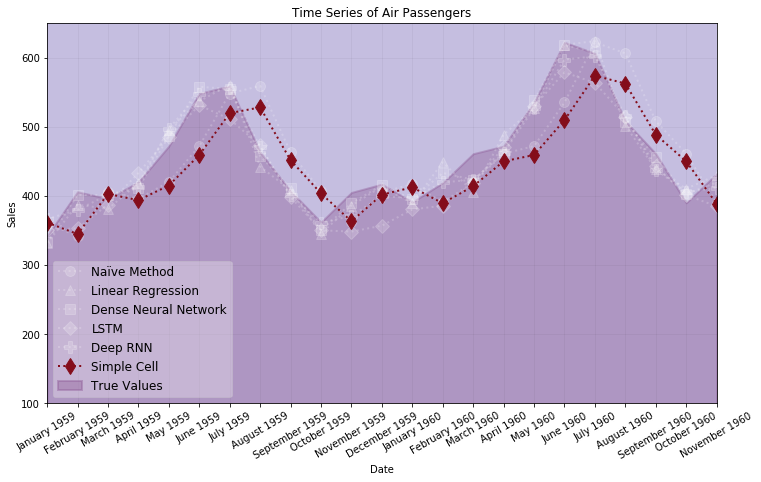

In [128]:
ax, figure = fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
plt.fill_between(X_test_copy.index, 0, y_test_copy, color='#8D5A97', linewidth=2, alpha=4e-1)

plt.plot(X_test_copy.index, y_pred_naive, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='o', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_reg, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='^', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_dense, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='s', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_lstm, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='D', markersize=10, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_drnn, color='#FFFFFF', linewidth=2, linestyle=':', 
         marker='P', markersize=12, alpha=2e-1)
plt.plot(X_test_copy.index, y_pred_cell, color='#840D1B', linewidth=2, linestyle=':', 
         marker='d', markersize=12)

locs, labels=plt.xticks(X_test_copy.index[::],  pd.to_datetime(df.Month[-24:]).dt.strftime('%B %Y'), rotation=30)
ax.set_facecolor('#C5BEE0')
plt.title('Time Series of Air Passengers')
plt.ylabel('Sales')
ax.legend(('Naïve Method', 'Linear Regression', 'Dense Neural Network', 'LSTM', 'Deep RNN', 
           'Simple Cell', 'True Values'), framealpha=0.3, fontsize='large')
plt.grid(True, alpha=0.05, color='black')
plt.ylim(100, 650)
plt.xlim(X_test_copy.index[0], X_test_copy.index[-1])
plt.xlabel('Date')
plt.show()

In [129]:
print('The mean absolute error with a simple cell neural network is %i'%mae_cell)

The mean absolute error with a simple cell neural network is 44


In [130]:
error_df = pd.concat([error_df, pd.DataFrame([mae_cell], index=['Simple Cell'], 
                                             columns=['Mean Absolute Error'])])
error_df

,Mean Absolute Error
Naïve,45.130435
Linear Regression,14.244720
Dense,8.832403
LSTM,24.819536
Deep RNN,13.736608
Simple Cell,44.890997


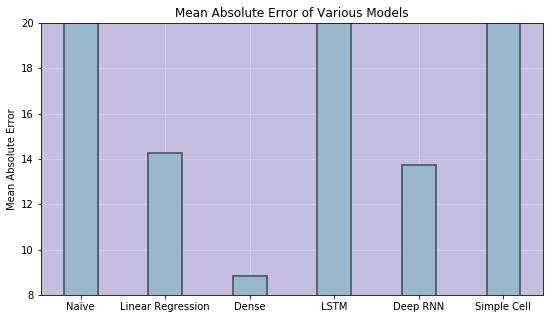

In [131]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 5))
color='#9BB7CC'
edgecolor='#556470'
ax.bar(error_df.index, height=error_df['Mean Absolute Error'], 
       color=color, width=4e-1, lw=2, edgecolor=edgecolor)
ax.set_ylim(8, 20)
ax.set_facecolor('#C5BEE0')
plt.title('Mean Absolute Error of Various Models')
ax.set_ylabel('Mean Absolute Error')
ax.grid(True, color='white', alpha=0.3)
ax.set_axisbelow(True)
plt.show()